In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from src.db import get_engine

In [3]:
from src.transform import (
    add_moving_averages,
    add_daily_returns,
    add_rsi
)

In [4]:
engine = get_engine(
    user="postgres",
    password="admin",
    host="localhost",
    port=5432,
    db="stock_data"
)

START_DATE = "2023-01-01"
TICKERS = ["TLKM.JK", "BBCA.JK", "AAPL"]

## Single-ticker price trend

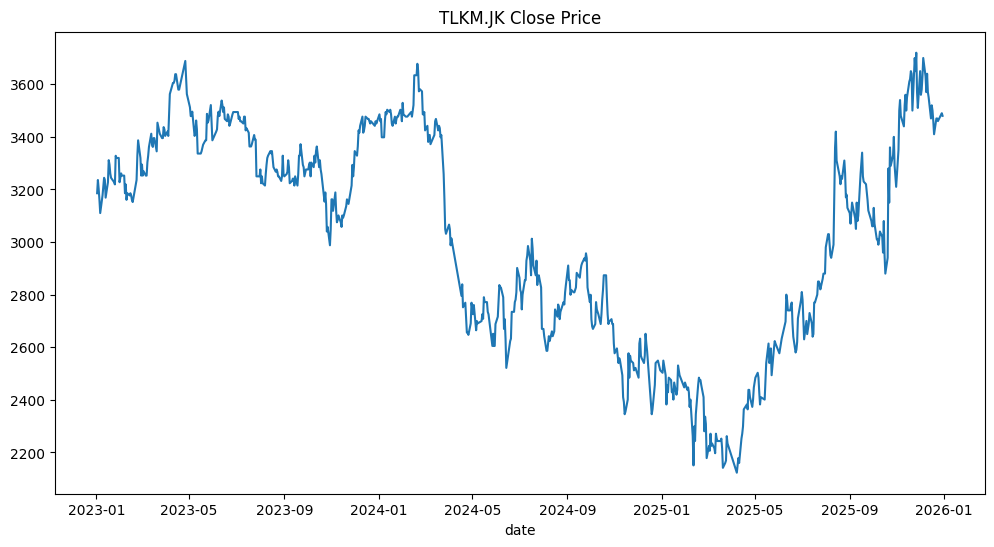

In [13]:
sql = """
SELECT date, close
FROM daily_prices
WHERE ticker = %(ticker)s
  AND date >= %(start)s
ORDER BY date;
"""

df = pd.read_sql(
    sql,
    engine,
    params={"ticker": "TLKM.JK", "start": START_DATE}
)

df.set_index("date", inplace=True)

df["close"].plot(figsize=(12, 6),title="TLKM.JK Close Price")
plt.show()

## Price + Moving Averages

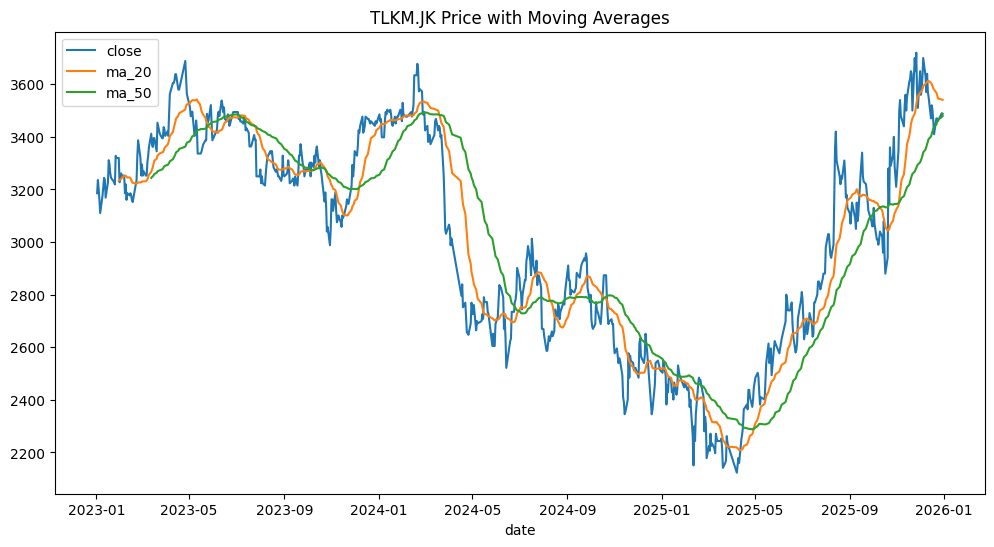

In [14]:
df["ma_20"] = df["close"].rolling(20).mean()
df["ma_50"] = df["close"].rolling(50).mean()

df[["close", "ma_20", "ma_50"]].plot(
    figsize=(12, 6),
    title="TLKM.JK Price with Moving Averages"
)
plt.show()

## Price + Volume

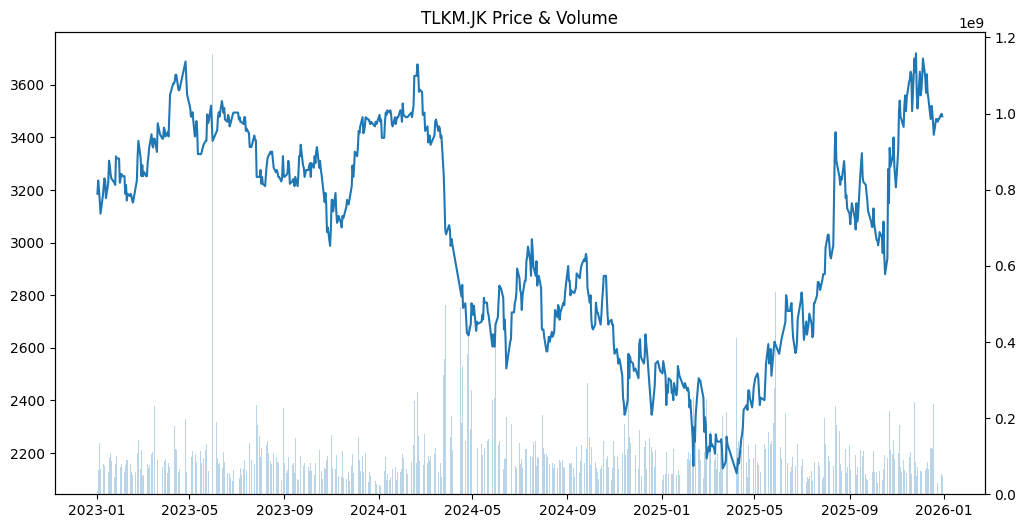

In [15]:
sql = """
SELECT date, close, volume
FROM daily_prices
WHERE ticker = %(ticker)s
  AND date >= %(start)s
ORDER BY date;
"""

df = pd.read_sql(
    sql,
    engine,
    params={"ticker": "TLKM.JK", "start": START_DATE}
)

df.set_index("date", inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df.index, df["close"])
ax2.bar(df.index, df["volume"], alpha=0.3)

ax1.set_title("TLKM.JK Price & Volume")
plt.show()


## RSI (14-day)

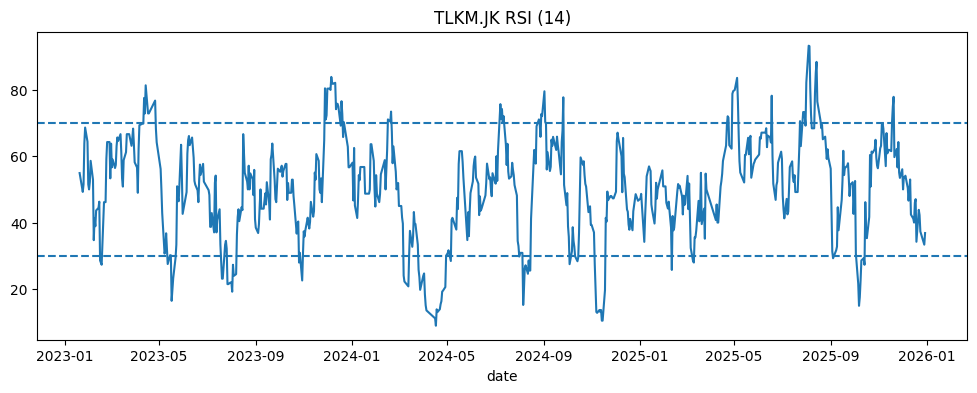

In [16]:
delta = df["close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))

df["rsi"].plot(figsize=(12, 4), title="TLKM.JK RSI (14)")
plt.axhline(70, linestyle="--")
plt.axhline(30, linestyle="--")
plt.show()


## Multi-ticker price comparison (raw)

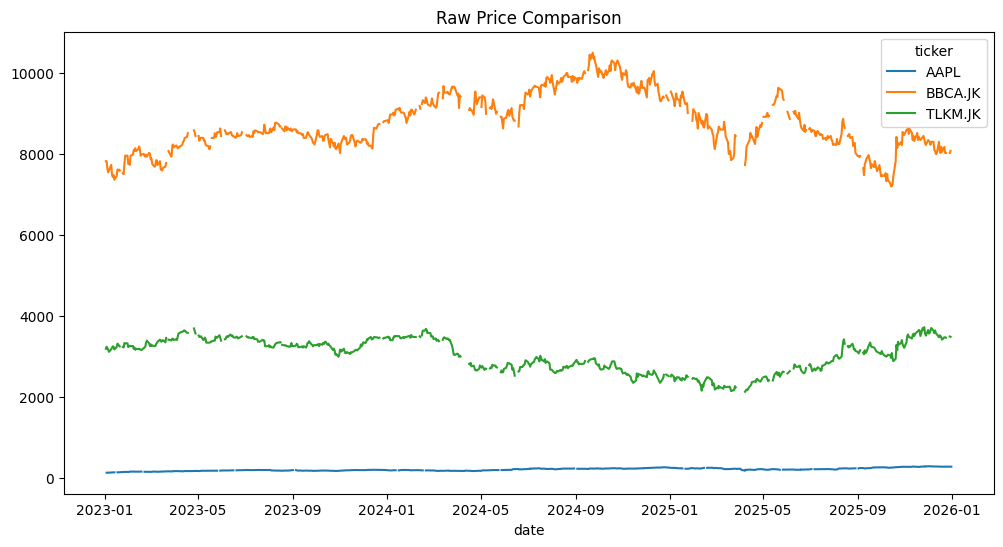

In [17]:
sql = """
SELECT date, ticker, close
FROM daily_prices
WHERE ticker = ANY(%(tickers)s)
  AND date >= %(start)s
ORDER BY date, ticker;
"""

df = pd.read_sql(
    sql,
    engine,
    params={"tickers": TICKERS, "start": START_DATE}
)

pivot = df.pivot(index="date", columns="ticker", values="close")

pivot.plot(figsize=(12, 6), title="Raw Price Comparison")
plt.show()


## Multi-ticker normalized comparison (key chart)

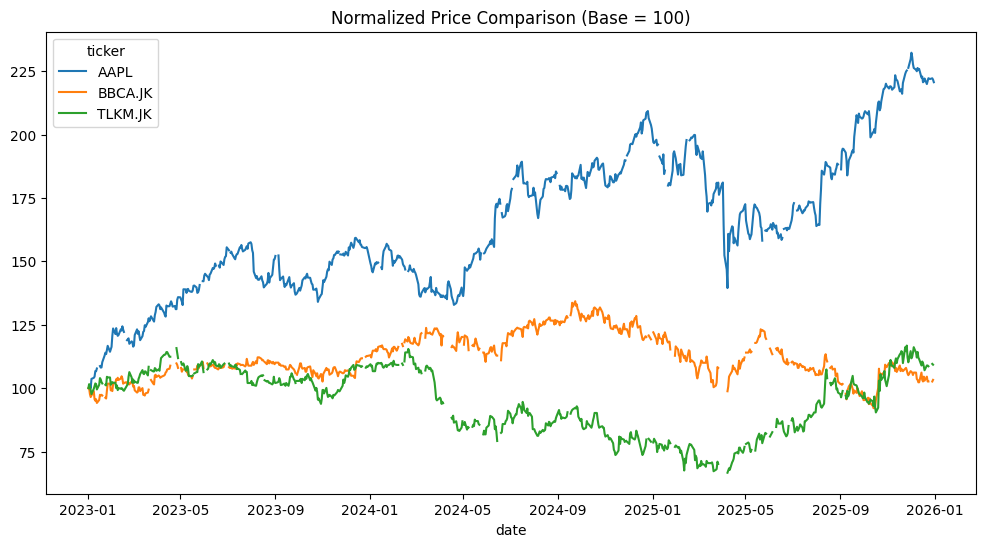

In [20]:
normalized = pivot.copy()

for col in normalized.columns:
    first_valid = normalized[col].dropna().iloc[0]
    normalized[col] = normalized[col] / first_valid * 100

normalized.plot(
    figsize=(12, 6),
    title="Normalized Price Comparison (Base = 100)"
)
plt.show()


## Rolling return comparison (30-day)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7040\4223242336.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot.pct_change()


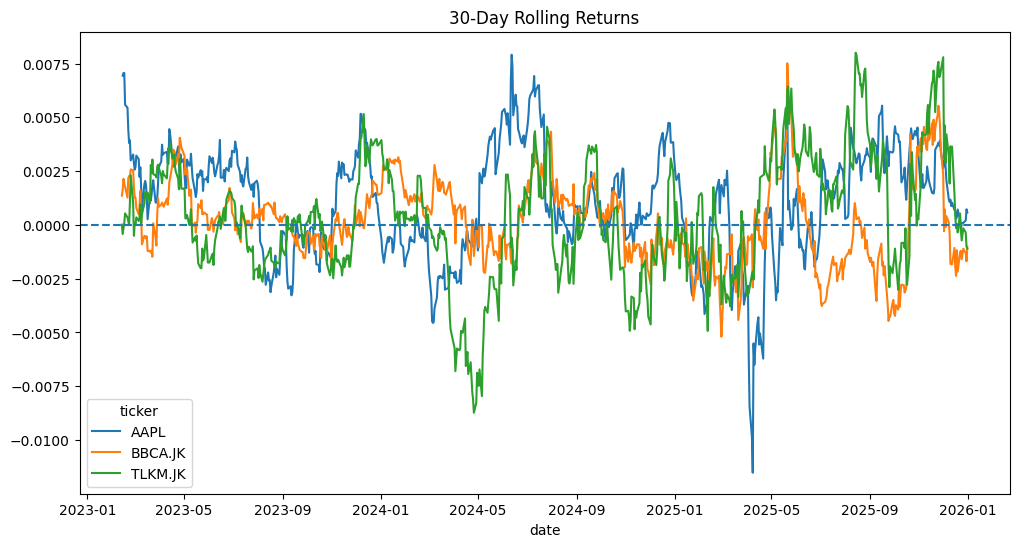

In [19]:
returns = pivot.pct_change()
rolling_30d = returns.rolling(30).mean()

rolling_30d.plot(figsize=(12, 6), title="30-Day Rolling Returns")
plt.axhline(0, linestyle="--")
plt.show()

## Correlation heatmap (daily returns)

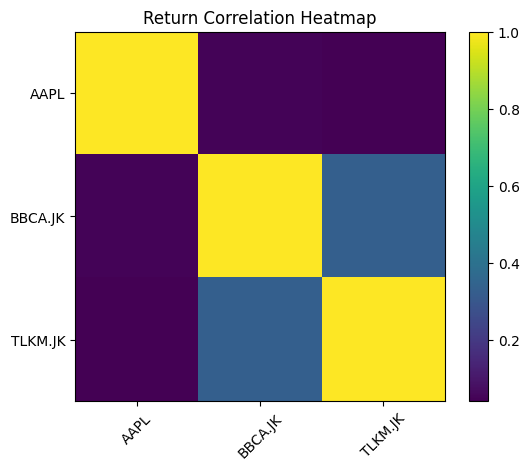

In [12]:
corr = returns.corr()

plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title("Return Correlation Heatmap")
plt.show()
